# LangGraph Application with a search tool

In [1]:
import os
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from get_llm import get_llm
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
# ------------ REPLACE THE TAVILY API KEY FOR YOURSELF, set it up in your .bashrc or env variables in windows -----------
# os.environ["TAVILY_API_KEY"] = ""
# -----------------------------------------------------------------------------------------------------------------------
llm = get_llm()
model = llm

C:\Users\ananth\anaconda3\envs\agentic_ai_dec2025_2026\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tool = TavilySearchResults(max_results=4) #increased number of results
print("Type of tool: ", type(tool))
print("Tool Name and Description: ", tool.name, ", ", tool.description)

Type of tool:  <class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
Tool Name and Description:  tavily_search_results_json ,  A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.


C:\Users\ananth\AppData\Local\Temp\ipykernel_68032\4010905469.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=4) #increased number of results


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [3]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

"""
The above is equivalent to:
{
    "messages": []
}
"""

'\nThe above is equivalent to:\n{\n    "messages": []\n}\n'

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [4]:
class AgentApp:

    def __init__(self, model, tools, system=""):
        self.system = system  # system message (prompt)

        # ------------------- define and compile the graph --------------
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)  # self.call_openai is our execute method
        graph.add_node("action", self.take_action)  # given an action description, perform the action and get the results
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        
        self.graph = graph.compile()
        
        # ---------------------- define tools and bind it to the LLM -------------------
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)
        # -------------------------------------------------------------------------------

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        result = len(result.tool_calls) > 0
        print("exists_action = ", result)
        return result

    def call_openai(self, state: AgentState):
        messages = state['messages']
        print("messages = ", messages)
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

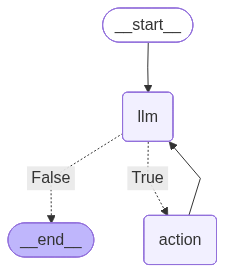

In [5]:
# prompt = """You are a smart research assistant. Use the search engine to look up information. \
# You are allowed to make multiple calls (either together or in sequence). \
# Only look up information when you are sure of what you want. \
# If you need to look up some information before asking a follow up question, you are allowed to do that!
# """

prompt = """You are a smart research assistant. Answer the query if you know the answer.
If you do not know the answer, use the search engine to look up information. 
You are allowed to make multiple calls (either together or in sequence). 
Only look up information when you are sure of what you want. When you already know the answer, just answer it and do not use the search tool.
For example when you are asked about a future event you can invoke a search tool.
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

# model = get_llm() #reduce inference cost
abot = AgentApp(model, [tool], system=prompt)
app = abot.graph
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [6]:
# from IPython.display import Image

# Image(abot.graph.get_graph().draw_png())

In [7]:
query = "What is NVidia's stock price?"
messages = [HumanMessage(content=query)]
result = abot.graph.invoke({"messages": messages})

messages =  [HumanMessage(content="What is NVidia's stock price?", additional_kwargs={}, response_metadata={})]
exists_action =  True
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'NVidia stock price'}, 'id': '859938118', 'type': 'tool_call'}
Back to the model!
messages =  [HumanMessage(content="What is NVidia's stock price?", additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 568, 'total_tokens': 609, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'gemma-3-12b-it', 'system_fingerprint': 'gemma-3-12b-it', 'id': 'chatcmpl-tqi2j84gbdoqplpyy17g', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--69d3f16d-7fa2-43f8-b618-ec3f9f12ddb8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'NVidia stock price'}, 'id': '859938118', 'type': 'tool_call'}], u

In [8]:
result

{'messages': [HumanMessage(content="What is NVidia's stock price?", additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 568, 'total_tokens': 609, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'gemma-3-12b-it', 'system_fingerprint': 'gemma-3-12b-it', 'id': 'chatcmpl-tqi2j84gbdoqplpyy17g', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--69d3f16d-7fa2-43f8-b618-ec3f9f12ddb8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'NVidia stock price'}, 'id': '859938118', 'type': 'tool_call'}], usage_metadata={'input_tokens': 568, 'output_tokens': 41, 'total_tokens': 609, 'input_token_details': {}, 'output_token_details': {}}),
  ToolMessage(content='[{\'title\': \'NVIDIA Stock Price History - Investing.com\', \'url\': \'https://www.investing.com/equities/nvidia-corp-hi

In [9]:
result['messages'][-1].content

"NVidia's stock price is currently $181.46 (as of December 2, 2025, according to Investor Relations). Other sources indicate a range from $176.50 to $179.29 today and a day's range of 180.00 - 185.66."

In [10]:
messages = [HumanMessage(content="Is NVidia more valued than Microsoft?")]
result = abot.graph.invoke({"messages": messages})

messages =  [HumanMessage(content='Is NVidia more valued than Microsoft?', additional_kwargs={}, response_metadata={})]
exists_action =  True
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'nvidia vs microsoft market cap'}, 'id': '700951985', 'type': 'tool_call'}
Back to the model!
messages =  [HumanMessage(content='Is NVidia more valued than Microsoft?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 567, 'total_tokens': 608, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'gemma-3-12b-it', 'system_fingerprint': 'gemma-3-12b-it', 'id': 'chatcmpl-q1u9p91cp2kep56cvte64m', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--eb26ccb3-e9b9-4546-9bcb-032ee76c09d8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'nvidia vs microsoft market cap'}, '

In [11]:
result['messages'][-1].content

"According to recent data from June 2025 and November 2025, Nvidia is currently more valuable than Microsoft. As of November 2025, Nvidia's market cap is $5.03 trillion, while Microsoft's is $3.6 trillion. In June 2025, Nvidia briefly surpassed Microsoft to regain the title of most valuable company in the world."

In [12]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "What is Machine Learning" 
messages = [HumanMessage(content=query)]

# model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = AgentApp(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

messages =  [HumanMessage(content='What is Machine Learning', additional_kwargs={}, response_metadata={})]
exists_action =  True
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'machine learning definition and examples'}, 'id': '470154447', 'type': 'tool_call'}
Back to the model!
messages =  [HumanMessage(content='What is Machine Learning', additional_kwargs={}, response_metadata={}), AIMessage(content='Machine learning (ML) is a field of artificial intelligence (AI) that focuses on enabling systems to learn from data without being explicitly programmed. Instead of relying on pre-defined rules, ML algorithms identify patterns in data and use those patterns to make predictions or decisions.\n\n', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 96, 'prompt_tokens': 563, 'total_tokens': 659, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'gemma-3-12b-it', 'system_fi

In [13]:
print(result['messages'][-1].content)

Okay, let's elaborate on that definition with the information I gathered.

Machine learning (ML) is a subfield of artificial intelligence (AI). It involves using algorithms trained on data sets to create models that can learn and make predictions or decisions without explicit programming. Essentially, instead of being told exactly how to perform a task, ML systems identify patterns in data and use those patterns to improve their performance over time.

Here's a breakdown of key aspects:

*   **How it works:** ML algorithms analyze large datasets to find patterns. These patterns are then used to build models that can predict outcomes or classify information.
*   **Examples:** Machine learning powers many everyday applications, including product recommendations (like on e-commerce sites), fraud detection in financial transactions, language translation (like Google Translate), and image recognition.
*   **Types:** There are different types of machine learning, with "supervised" learning b

In [14]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Which is the capital of India?" 
messages = [HumanMessage(content=query)]

# model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = AgentApp(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

messages =  [HumanMessage(content='Which is the capital of India?', additional_kwargs={}, response_metadata={})]
exists_action =  False


In [15]:
result["messages"][-1].content

'New Delhi is the capital of India.'

### Another example

In [16]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Can you prove that a non deterministic finite automata (NFA) can be transformed to a deterministic finite automata (DFA)? Do not use any external tool." 
messages = [HumanMessage(content=query)]

# model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = AgentApp(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

messages =  [HumanMessage(content='Can you prove that a non deterministic finite automata (NFA) can be transformed to a deterministic finite automata (DFA)? Do not use any external tool.', additional_kwargs={}, response_metadata={})]
exists_action =  False


In [17]:
print(result['messages'][-1].content)

Yes, it is possible to transform an NFA into a DFA. This transformation is proven and well-established in the theory of computation. Here's a breakdown of the proof, often referred to as the "subset construction":

**The Subset Construction Algorithm:**

1. **Initial State:** The initial state of the DFA is the ε-closure (set of states reachable from the initial state via ε-transitions) of the initial state of the NFA.  The ε-closure is crucial for handling the non-determinism.

2. **Transition Function:** For each state *q* in the DFA and each input symbol *a*:
   * Compute the set of states reachable from *q* via an *a*-transition in the NFA, considering all possible paths (due to non-determinism). This involves taking the union of all sets of states that can be reached by following *a*-transitions.  Crucially, after each transition, take the ε-closure of the resulting set.
   * If this resulting set is not empty, it becomes a new state in the DFA.  If it's empty, there's no correspo

### Tighter Prompt

In [ ]:
prompt1 = """
You are a highly capable and knowledgeable research assistant.
Answer user questions directly using your own knowledge whenever possible.

Only use the search tool when you are genuinely uncertain or when the information is likely to be time-sensitive, future-dated, highly specific, or obscure.

Do not use the search tool for well-known, general knowledge questions. Examples include definitions, concepts, widely-known facts, or questions about known topics 

Search is expensive. Avoid unnecessary searches.

You may make multiple searches if needed, but only after carefully considering whether it is necessary.

🔔 When to search:
✅ Questions about future events
✅ Current news, prices, recent changes
✅ Specific or uncommon details you’re unsure about
✅ Things you know require recent verification

🚫 When NOT to search:
❌ General knowledge you already understand
❌ Definitions of common concepts
❌ Facts you are confident about

🔑 Important Instruction:
If you know the answer confidently, answer immediately. Do not invoke the search tool.

If you are unsure, think through the question step-by-step before deciding whether to search.

"""

In [ ]:
query = "Who won the womens world cup finals cricket match last weekend?" 
messages = [HumanMessage(content=query)]

# model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = AgentApp(model, [tool], system=prompt1)
result = abot.graph.invoke({"messages": messages})

In [ ]:
print(result['messages'][-1].content)